### Research goals: Predicting incidence of breast cancer given image data of breast masses.

In [9]:

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# Reference for customizing plots : http://matplotlib.org/users/customizing.html
# print(plt.style.available)


import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
data = load_breast_cancer()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)
print("Classes {}".format(np.unique(y)))
print 
print data.DESCR


Classes [0 1]

Breast Cancer Wisconsin (Diagnostic) Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Ra

In [10]:
from sklearn.metrics import f1_score

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

models = {'gb':GradientBoostingClassifier(), 
          'mlp':MLPClassifier(), 
          'knn':KNeighborsClassifier(), 
          'reg':LogisticRegression()}

for model_key in models:
    model = models[model_key]
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    f1 = f1_score(y_test, preds)
    print "F1 for {0}: {1}".format(model_key, f1)


F1 for knn: 0.937062937063
F1 for mlp: 0.767567567568
F1 for gb: 0.965986394558
F1 for reg: 0.930555555556


2017-05-11 20:33:51,989 - skater.core.explanations - INFO - Loading Data
2017-05-11 20:33:51,990 - skater.data.datamanager - DEBUG - __init__ data.shape: (114, 30)
2017-05-11 20:33:51,992 - skater.data.datamanager - DEBUG - after transform data.shape: (114, 30)
2017-05-11 20:33:51,992 - skater.core.explanations - INFO - Data loaded
2017-05-11 20:33:51,993 - skater.core.explanations - DEBUG - Data shape: (114, 30)
2017-05-11 20:33:51,994 - skater.core.explanations - DEBUG - Dataset Feature_ids: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concav

(<matplotlib.figure.Figure at 0x7fb1c3d5e190>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb1c3d29110>)

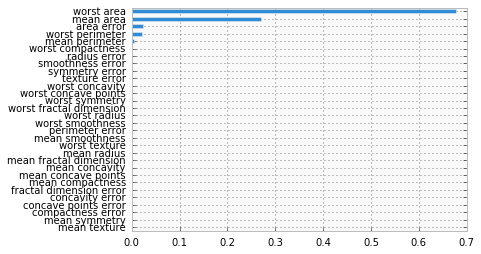

In [11]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
interpreter = Interpretation(X_test, feature_names=data.feature_names, log_level=10)
model = InMemoryModel(models['knn'].predict_proba, examples=X_train)
interpreter.feature_importance.plot_feature_importance(model)

### Skater also works with classifiers without probability scores

(<matplotlib.figure.Figure at 0x7fb1dbf24650>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb1db2e1c10>)

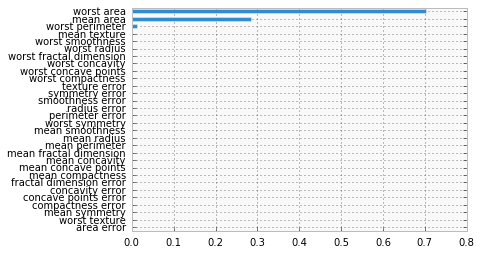

In [13]:

model_no_proba = InMemoryModel(models['knn'].predict, 
                      examples=X_train, 
                      unique_values=models['knn'].classes_)
interpreter.feature_importance.plot_feature_importance(model_no_proba)

### KNN looks to be the best classifier of the set. what now?

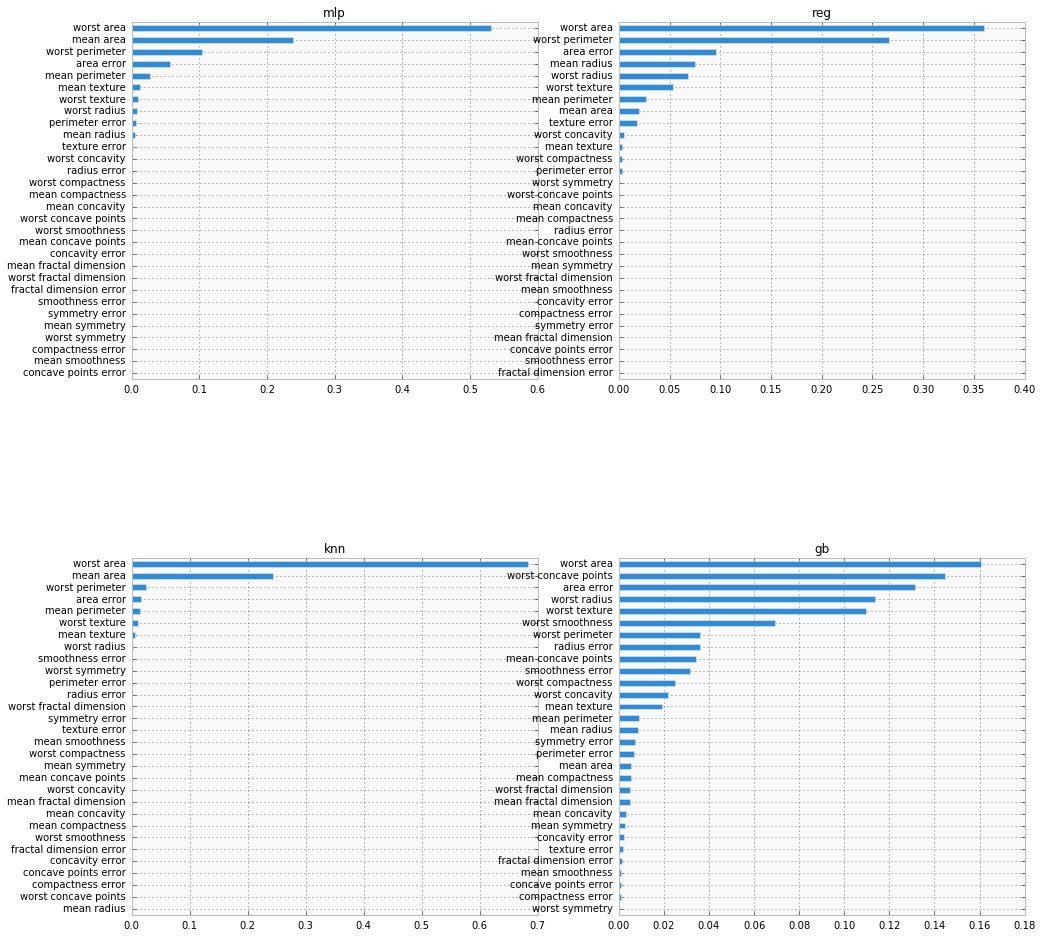

In [4]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

f, axes = plt.subplots(2,2, figsize = (16, 16))

ax_dict = {
    'mlp':axes[0][0],
    'knn':axes[1][0],
    'reg':axes[0][1],
    'gb':axes[1][1]
}

interpreter = Interpretation(X_test, feature_names=data.feature_names)

for model_key in models:
    pyint_model = InMemoryModel(models[model_key].predict_proba, examples=X_train)
    ax = ax_dict[model_key]
    interpreter.feature_importance.plot_feature_importance(pyint_model, ax=ax)
    ax.set_title(model_key)

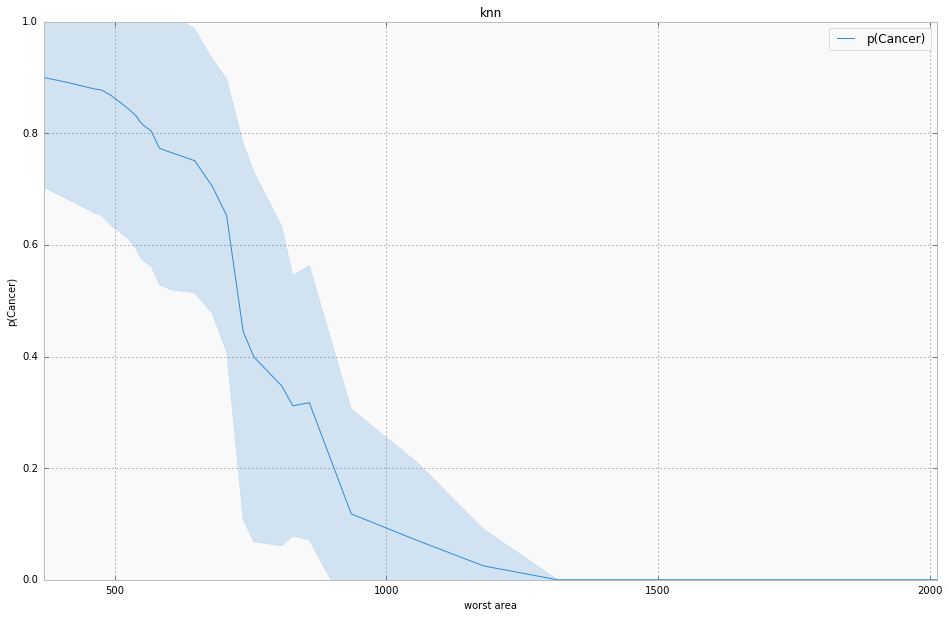

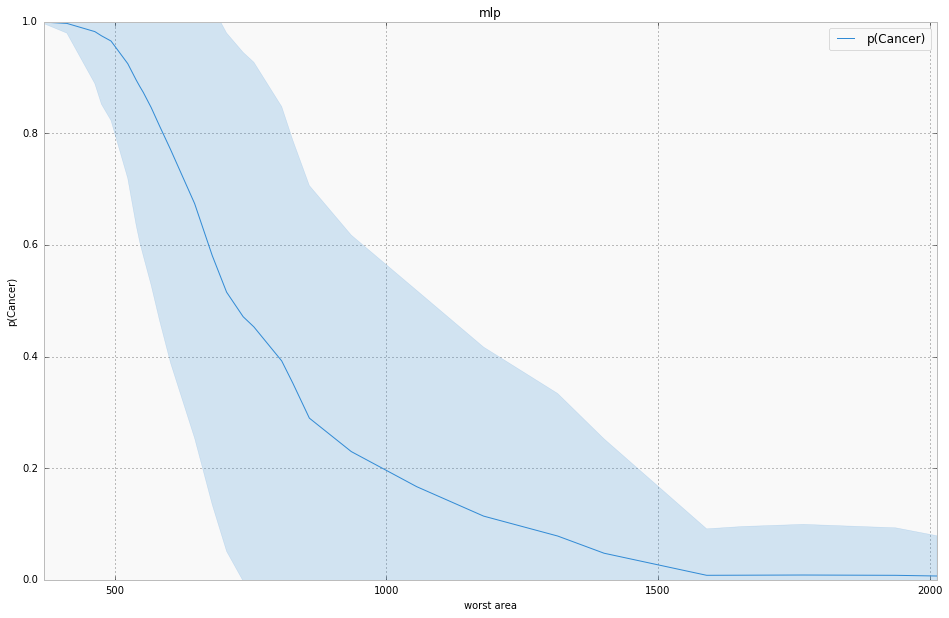

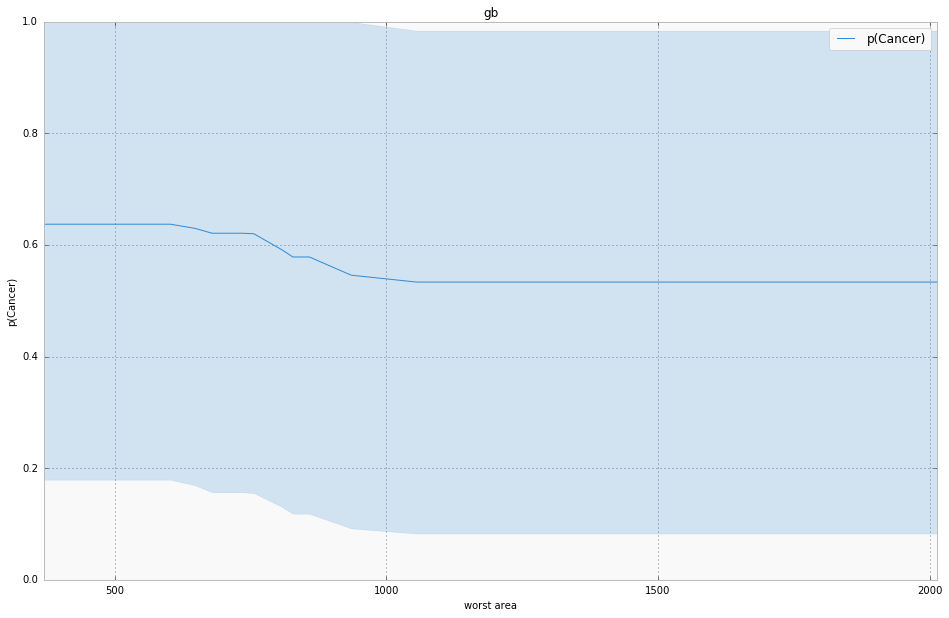

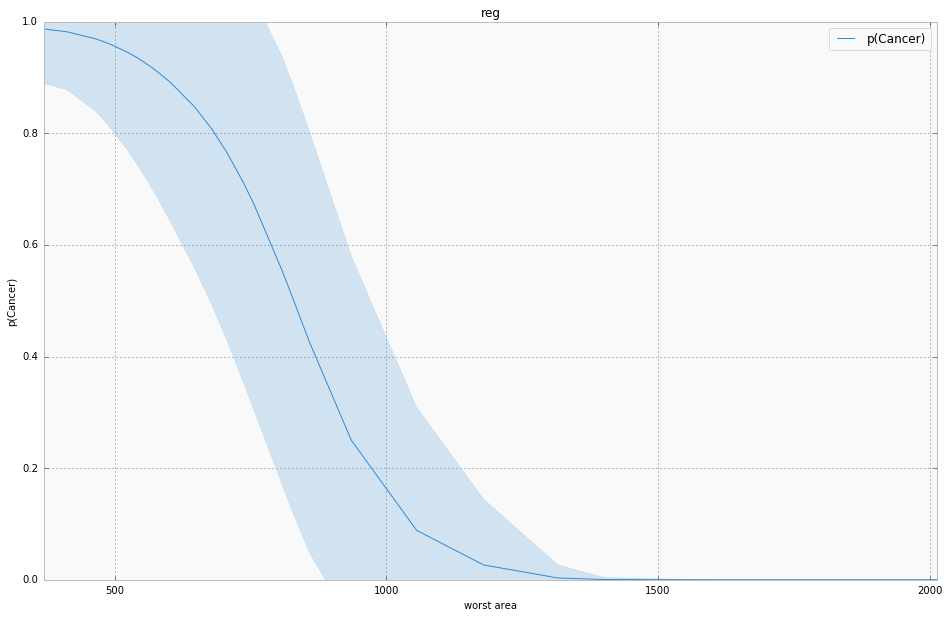

In [5]:

for model_key in models:
    pyint_model = InMemoryModel(models[model_key].predict_proba, examples=X_train, target_names=['p(No Cancer)', 'p(Cancer)'])
    axes_list = interpreter.partial_dependence.plot_partial_dependence(['worst area'],
                                                                       pyint_model, 
                                                                       grid_resolution=30, 
                                                                      with_variance=True)
    ax = axes_list[0][1]
    ax.set_title(model_key)
    ax.set_ylim(0, 1)

### Why isnt gb as sensitive to worst area? Feature importance indicates gb uses more features, perhaps theres additivity?

In [6]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer
exp = LimeTabularExplainer(X_train, 
                           feature_names=data.feature_names, 
                           discretize_continuous=False, 
                           class_names=['p(No Cancer)', 'p(Cancer)'])
exp.explain_instance(X_train[0], models['gb'].predict_proba).show_in_notebook()

In [7]:
exp.explain_instance(X_train[0], models['knn'].predict_proba).show_in_notebook()

### Interaction between worst area and perimeter for gb model?

[[<matplotlib.figure.Figure at 0x7fb1db4d0a90>,

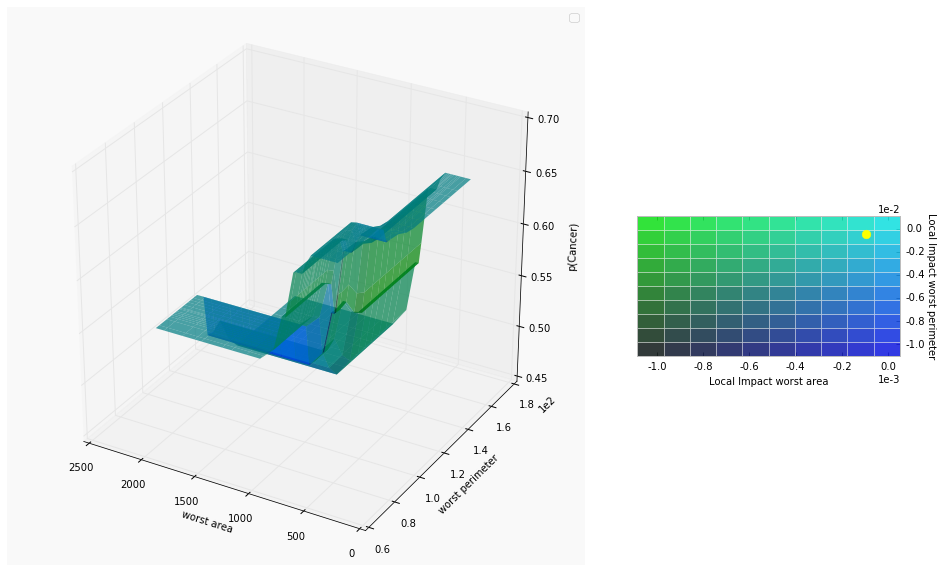

In [8]:
model = InMemoryModel(models['gb'].predict_proba, examples=X_train, target_names=['p(No Cancer)', 'p(Cancer)'])
interpreter.partial_dependence.plot_partial_dependence([('worst area', 'worst perimeter')], model, grid_resolution = 30)